In [1]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
train_df = pd.read_csv('datasets/used_car_train_20200313.csv', sep=' ')
test_df = pd.read_csv('datasets/used_car_testA_20200313.csv', sep=' ')

print('train data shape: ', train_df.shape)
print('test data shape: ', test_df.shape)

train data shape:  (150000, 31)
test data shape:  (50000, 30)


## EDA

In [3]:
train_df.head(10)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
5,5,137642,20090602,24.0,10,0.0,1.0,0.0,109,10.0,...,0.260246,0.000518,0.119838,0.090922,0.048769,1.885526,-2.721943,2.457660,-0.286973,0.206573
6,6,2402,19990411,13.0,4,0.0,0.0,1.0,150,15.0,...,0.267998,0.117675,0.142334,0.025446,0.028174,-4.902200,1.610616,-0.834605,-1.996117,-0.103180
7,7,165346,19990706,26.0,14,1.0,0.0,0.0,101,15.0,...,0.239506,0.000000,0.122943,0.039839,0.082413,3.693829,-0.245014,-2.192810,0.236728,0.195567
8,8,2974,20030205,19.0,1,2.0,1.0,1.0,179,15.0,...,0.263833,0.116583,0.144255,0.039851,0.024388,-4.925234,1.587796,0.075348,-1.551098,0.069433
9,9,82021,19980101,7.0,7,5.0,0.0,0.0,88,15.0,...,0.262473,0.068267,0.012176,0.010291,0.098727,-1.089584,0.600683,-4.186210,0.198273,-1.025822


In [4]:
train_df.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [5]:
train_df.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [7]:
train_df.corr(method='pearson').sort_values(by='price')['price']

v_3          -0.730946
kilometer    -0.440519
v_11         -0.275320
v_10         -0.246175
v_9          -0.206205
v_4          -0.147085
v_7          -0.053024
brand        -0.043799
v_13         -0.013993
seller       -0.002004
SaleID       -0.001043
name          0.002030
creatDate     0.002955
regionCode    0.014036
v_14          0.035911
v_1           0.060914
v_6           0.068970
v_2           0.085322
model         0.136983
v_5           0.164317
fuelType      0.200536
power         0.219834
bodyType      0.241303
gearbox       0.329075
regDate       0.611959
v_0           0.628397
v_8           0.685798
v_12          0.692823
price         1.000000
offerType          NaN
Name: price, dtype: float64

## 特征工程

In [8]:
def stat_inf(data):
    # 定义统计函数
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))    

In [17]:
feature_cols = [col for col in train_df.columns if col not in ['SaleID','name','regDate','creatDate','model','brand','regionCode','seller','notRepairedDamage','price']]
feature_cols = [col for col in feature_cols if 'Type' not in col]
X_data = train_df[feature_cols]
Y_data = train_df['price']
X_test  = test_df[feature_cols]

print("X_data shape: ", X_data.shape)
print("Y_data shape: ", Y_data.shape)
print("X_data shape: ", X_test.shape)


X_data shape:  (150000, 18)
Y_data shape:  (150000,)
X_data shape:  (50000, 18)


In [18]:
print('sta of label:')
stat_inf(Y_data)

sta of label:
_min 11
_max: 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876438
_var 56279605.94272992


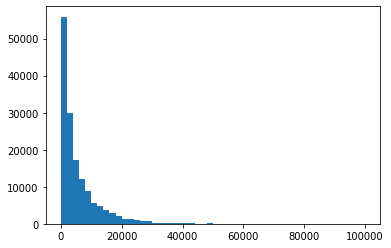

In [19]:
## 绘制标签的统计图，查看标签分布
plt.hist(Y_data, bins=50)
plt.show()

In [20]:
# 缺省值 暂时用-1填补

X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

## 模型训练

In [21]:
import lightgbm as lgb
import xgboost as xgb

In [22]:
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) 
scores_train = []
scores = []


In [39]:
## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

Train mae: 622.5257847110195
Val mae 711.5154933383245


In [46]:
result_df = test_df[['SaleID']]

In [49]:
result_df['price'] = xgr.predict(X_test.values)

In [51]:
result_df.to_csv('sample_submit.csv')

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error



from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

estimator = LinearRegression()
estimator = GridSearchCV(estimator, param_grid={}, cv=5)
estimator.fit(X_data, Y_data)
Y_predict_data = estimator.predict(X_data)

mae = mean_absolute_error(Y_data, Y_predict_data)
print('MAE {}'.format(mae))


MAE 2613.950463675995


In [34]:
result_df = train_df[['SaleID','price']]

In [36]:
result_df['predict_price'] = Y_predict_data

In [38]:
result_df.to_csv('tmp.csv')